In [1]:
!pip install rdkit-pypi
!pip install numpy
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 58.4 MB/s eta 0:00:00


In [3]:

import time
import random
import sys
from pathlib import Path
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps

# show full results
np.set_printoptions(threshold=sys.maxsize)


# Reading the input CSV file.

ligands_df = pd.read_csv("generated_molecules.csv", header=None, names=["SMILES"])
print(ligands_df.head())

                                SMILES
0                               SMILES
1  O(C)NCCC(O)C1=CC(=O)[NH1]C(=O)N1C=O
2                           O=SOP(Cl)C
3                                   FC
4                                  N=O


[22:49:50] SMILES Parse Error: syntax error while parsing: SMILES
[22:49:50] SMILES Parse Error: Failed parsing SMILES 'SMILES' for input: 'SMILES'


Number of fingerprints: 989


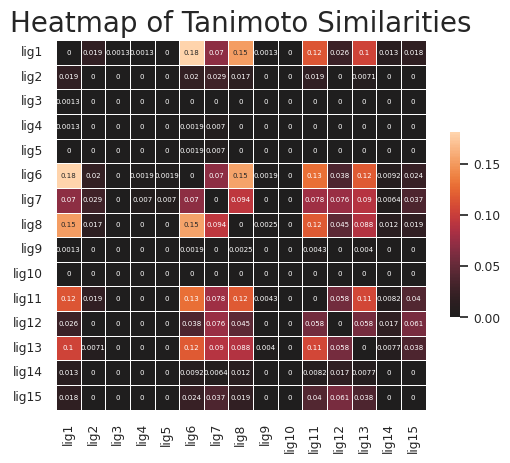

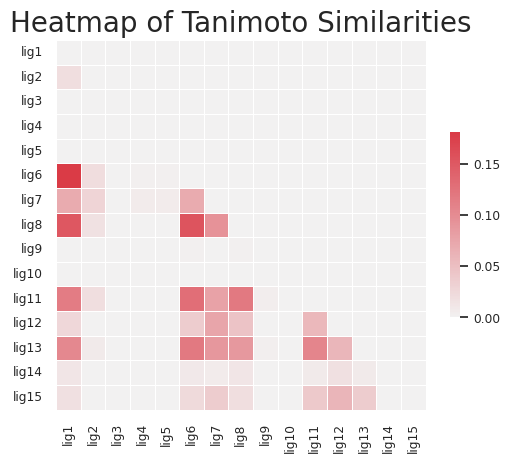

In [4]:
# Creating molecules and storing in an array
molecules = []

"""Let's fetch the smiles from the input file and store in molecules array
        We have used '_' because we don't want any other column.
        If you want to fetch index and any other column, then replace '_' with
            index and write column names after a ','.
"""

for _, smiles in ligands_df[[ "SMILES"]].itertuples():
    mol = Chem.MolFromSmiles(smiles)
    # Check if the molecule was successfully created
    if mol is not None:
        molecules.append(mol)
    else:
        print(f"Warning: Invalid SMILES string: {smiles}")  # Print a warning for invalid SMILES

molecules[:15]


# Creating fingerprints for all molecules

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)
fgrps = [rdkit_gen.GetFingerprint(mol) for mol in molecules]


# Calculating number of fingerprints
nfgrps = len(fgrps)
print("Number of fingerprints:", nfgrps)


# Defining a function to calculate similarities among the molecules
def pairwise_similarity(fingerprints_list):

    global similarities

    similarities = np.zeros((nfgrps, nfgrps))

    for i in range(1, nfgrps):
            similarity = DataStructs.BulkTanimotoSimilarity(fgrps[i], fgrps[:i])
            similarities[i, :i] = similarity
            similarities[:i, i] = similarity

    return similarities


# Calculating similarities of molecules
pairwise_similarity(fgrps)
tri_lower_diag = np.tril(similarities, k=0)


# Visulaizing the similarities

# definging labels to show on heatmap
labels = ['lig1','lig2','lig3','lig4','lig5','lig6','lig7', 'lig8', 'lig9', 'lig10', 'lig11', 'lig12', 'lig13', 'lig14', 'lig15']


def normal_heatmap (sim):

    # writing similalrities to a file
    f = open("similarities.txt", "w")
    print (similarities, file=f)

    sns.set(font_scale=0.8)

    # generating the plot

    plot = sns.heatmap(sim[:15,:15], annot = True, annot_kws={"fontsize":5}, center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})

    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20) # title with fontsize 20

    plt.show()

    # saving the plot

    fig = plot.get_figure()
    fig.savefig("tanimoto_heatmap.png")


def lower_tri_heatmap (sim):
    f = open("similarities_lower_tri.txt", "w")

    print (tri_lower_diag, file=f)

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    lower_tri_plot = sns.heatmap(tri_lower_diag[:15,:15], annot = False, cmap=cmap,center=0,
            square=True, xticklabels=labels, yticklabels=labels, linewidths=.7, cbar_kws={"shrink": .5})

    plt.title('Heatmap of Tanimoto Similarities', fontsize = 20)

    plt.show()

    fig = lower_tri_plot.get_figure()
    fig.savefig("tanimoto_heatmap_lw_tri.png")


normal_heatmap(similarities)

lower_tri_heatmap(similarities)